In [1]:
from PIL import Image
import numpy as np
import cv2
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [2]:
import numpy as np

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

data = []
labels = []
for i in range(5):
    batch = unpickle(f"../data/raw/data_batch_{i+1}")
    data.append(batch[b"data"])
    labels.extend(batch[b"labels"])

Xtemp, y = np.concatenate(data), np.array(labels)

In [3]:
from PIL import Image

def convert_to_image(data, index):
    single_image_data = data[index]
    single_image_data = single_image_data.reshape((3, 32, 32))
    single_image_data = single_image_data.transpose((1, 2, 0))

    img = Image.fromarray(single_image_data, 'RGB')
    return img

X = []
for i in range(len(Xtemp)):
    X.append(convert_to_image(Xtemp, i))

In [4]:
def extract_dominant_colors(image: Image, k=3):
    image = image.convert('RGB')
    np_img = np.array(image)
    np_img = np_img.reshape(-1, 3)
    
    kmeans = KMeans(n_clusters=k, n_init="auto")
    kmeans.fit(np_img)

    return kmeans.cluster_centers_

In [5]:
def compute_sift(image: Image):
    sift = cv2.xfeatures2d.SIFT_create()
    gray = cv2.cvtColor(np.array(image.convert('RGB')), cv2.COLOR_RGB2GRAY)
    _, des = sift.detectAndCompute(gray, None)
    
    if des is None:
        des = np.array([])
    
    return des

In [6]:
from sklearn.cluster import MiniBatchKMeans

sift_features_list = []
dominant_colors_list = []
labels_processed = []

for img, lbl in zip(X, y):
    sift_features = compute_sift(img)
    dominant_colors = extract_dominant_colors(img)
    
    if sift_features is not None and sift_features.size > 0:
        sift_features_list.append(sift_features)
        dominant_colors_list.append(dominant_colors)
        labels_processed.append(lbl)

In [7]:
all_sift_features = np.vstack(sift_features_list)
n_features = all_sift_features.shape[0]
n_clusters = min(n_features, 350)

kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(all_sift_features)

c:\Users\RINGULARITY\.conda\envs\ml\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


MiniBatchKMeans(n_clusters=350, random_state=0)

In [8]:
features = []

for sift_features, dominant_colors in zip(sift_features_list, dominant_colors_list):
    histogram = np.zeros(n_clusters)
    words = kmeans.predict(sift_features)
    for w in words:
        histogram[w] += 1
    
    features.append(np.hstack([dominant_colors.ravel(), histogram]))

# Convert list to array
features = np.array(features)
labels_processed = np.array(labels_processed)

In [9]:
from sklearn.preprocessing import StandardScaler

features = StandardScaler().fit_transform(features)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(features, labels_processed, test_size=0.2, random_state=42)

In [11]:
X_train.shape

(39924, 359)

In [17]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score

scores = []

def objective(params):
    model = XGBClassifier(**params, learning_rate=0.1, tree_method="gpu_hist")
    model.fit(X_train, y_train)
    score = cross_val_score(model, X_train, y_train, cv=3).mean()
    scores.append(score)
    print(f'Score {score}, n_estimators {params["n_estimators"]}, max_depth {params["max_depth"]}')
    return {'loss': -score, 'status': STATUS_OK}

space = {
    'n_estimators': hp.choice('n_estimators', range(100, 350)),
    'max_depth': hp.choice('max_depth', range(5, 15))
}

best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=30, trials=Trials())

  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

Score 0.341198276725779, n_estimators 108, max_depth 8
Score 0.35136759843703036, n_estimators 195, max_depth 7                        
Score 0.3455565574591724, n_estimators 206, max_depth 13                          
Score 0.3457068430017032, n_estimators 295, max_depth 14                          
Score 0.35607654543632905, n_estimators 321, max_depth 7                             
Score 0.35730387736699726, n_estimators 330, max_depth 7                             
Score 0.3510169321711252, n_estimators 261, max_depth 11                           
Score 0.352544835186855, n_estimators 275, max_depth 9                             
Score 0.34733493637912033, n_estimators 194, max_depth 5                           
Score 0.3501653140967839, n_estimators 170, max_depth 7                            
Score 0.3453311291453762, n_estimators 267, max_depth 14                           
Score 0.3420999899809638, n_estimators 115, max_depth 12                            
Score 0.3482616972247

In [19]:
model = XGBClassifier(**best)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

Accuracy: 0.3554754032662058


[0]	train-mlogloss:2.24709	eval-mlogloss:2.26444
[10]	train-mlogloss:1.92978	eval-mlogloss:2.06586
[20]	train-mlogloss:1.76358	eval-mlogloss:1.98302
[30]	train-mlogloss:1.64982	eval-mlogloss:1.93511
[40]	train-mlogloss:1.56484	eval-mlogloss:1.90209
[50]	train-mlogloss:1.49352	eval-mlogloss:1.87755
[60]	train-mlogloss:1.42979	eval-mlogloss:1.85631
[70]	train-mlogloss:1.37269	eval-mlogloss:1.83999
[80]	train-mlogloss:1.31911	eval-mlogloss:1.82546
[90]	train-mlogloss:1.27048	eval-mlogloss:1.81360
[99]	train-mlogloss:1.23154	eval-mlogloss:1.80478


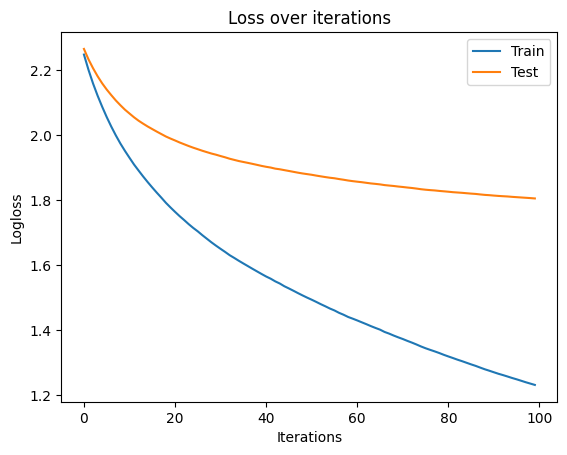

In [24]:
import xgboost as xgb
import matplotlib.pyplot as plt

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'multi:softprob',
    'num_class': 10,
    'eval_metric': 'mlogloss',
    'eta': 0.1,
    'max_depth': 8,
}

evals = [(dtrain, 'train'), (dvalid, 'eval')]

num_round = 1000
evals_result = {}
bst = xgb.train(params, dtrain, num_round, evals=evals, evals_result=evals_result, verbose_eval=100)

train_errors = evals_result['train']['mlogloss']
plt.plot(train_errors, label='Train')

eval_errors = evals_result['eval']['mlogloss']
plt.plot(eval_errors, label='Test')

plt.title('Loss over iterations')
plt.xlabel('Iterations')
plt.ylabel('Logloss')
plt.legend()
plt.show()

In [26]:
y_pred = model.predict(X_test)

np.mean(y_pred == y_test)

0.3554754032662058

<Axes: >

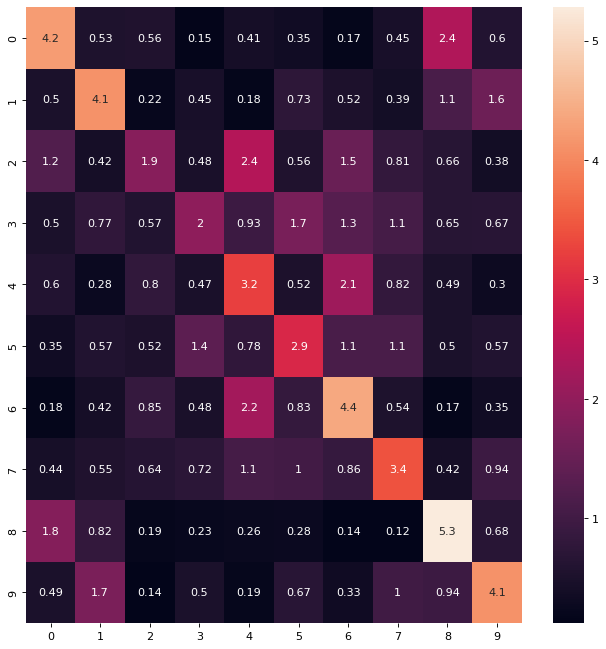

In [27]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from seaborn import heatmap

cm = confusion_matrix(y_test, y_pred)
cm = 100 * cm / np.sum(np.sum(cm))

plt.figure(figsize=(10, 10), dpi=80)
heatmap(cm, annot=True)